In [16]:
!pip install ultralytics

In [17]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from ultralytics import YOLO
from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import time
from tqdm.notebook import tqdm
import os
from google.colab.patches import cv2_imshow
#Flujo:
#Recibe imagen -- resize para segmentacion?
#Segmentación -- normalizar imagenet / resize modelo efficient
#Clasificación -- llamar modelo con la imagen resultante
#Arrojar clasificación y la probabilidad

In [18]:
RUTA_MODELO_SEG = '/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/best_seg.pt'
RUTA_MODELO_CLASIF = '/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/efficientNet_sign_language_seg.pth' # El que guardaste
IMG_SIZE = 224
CONF_THRESHOLD_SEG = 0.6 # Umbral para segmentación

CLASS_NAMES = sorted([
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U',
    'V', 'W', 'X', 'Y', 'Z'
])
NUM_CLASSES = len(CLASS_NAMES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones de VALIDACIÓN (para inferencia)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

try:
    model_seg = YOLO(RUTA_MODELO_SEG)
    model_seg.to(device)
    print("Modelo de Segmentación (YOLO) cargado exitosamente.")
except Exception as e:
    print(f"Error cargando modelo de segmentación: {e}")

try:
    #EfficientNet B0
    model_clasif = models.efficientnet_b0(weights=None) # No necesitamos pesos preentrenados aquí

    # Modificar la capa final
    in_features = model_clasif.classifier[1].in_features
    model_clasif.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

    # Cargar pesos entrenados (.pth)
    model_clasif.load_state_dict(torch.load(RUTA_MODELO_CLASIF, map_location=device))
    model_clasif.to(device)

    #Modelo en modo de evaluación
    model_clasif.eval()
    print("Modelo de Clasificación (EfficientNet) cargado exitosamente.")

except Exception as e:
    print(f"Error cargando modelo de clasificación: {e}")

#Mapa de etiquetas
label_map_inverso = {idx: class_name for idx, class_name in enumerate(CLASS_NAMES)}

#Pipeline segmentación y clasificación

def clasificar_mano(ruta_imagen):
    try:
        #Cargar Imagen OpenCV
        img_original_bgr = cv2.imread(ruta_imagen)
        if img_original_bgr is None:
            return "Error", 0.0, "No se pudo leer la imagen."

        # Segmentación YOLO
        resultados_seg = model_seg.predict(img_original_bgr, conf=CONF_THRESHOLD_SEG, verbose=False)

        if resultados_seg[0].masks is None:
            return "N/A", 0.0, "No se detectó ninguna mano."

        #Preprocesamiento
        # Encontrar la máscara con el área más grande
        mascara_principal = max(resultados_seg[0].masks, key=lambda m: cv2.contourArea(m.xy[0]))

        # Crear la máscara binaria del tamaño original
        mascara_binaria = np.zeros(img_original_bgr.shape[:2], dtype=np.uint8)
        contorno_principal = mascara_principal.xy[0].astype(np.int32)
        cv2.fillPoly(mascara_binaria, [contorno_principal], 255)

        # Aplicar el fondo negro
        img_fondo_negro = cv2.bitwise_and(img_original_bgr, img_original_bgr, mask=mascara_binaria)

        # Convertir de NumPy (OpenCV/BGR) a PIL (Torch/RGB)
        img_pil = Image.fromarray(cv2.cvtColor(img_fondo_negro, cv2.COLOR_BGR2RGB))

        # Aplicar las transformaciones (Resize, ToTensor, Normalize)
        input_tensor = val_transform(img_pil)

        # Añadir la dimensión del lote (batch dimension)
        input_tensor = input_tensor.unsqueeze(0).to(device)

        #Clasificación
        with torch.no_grad(): # Desactiva el cálculo de gradientes
            logits = model_clasif(input_tensor)

            probabilidades = F.softmax(logits, dim=1)
            confianza, pred_idx = torch.max(probabilidades, dim=1)

            letra_predicha = label_map_inverso[pred_idx.item()]
            confianza_predicha = confianza.item()

            return letra_predicha, confianza_predicha, "Éxito"

    except Exception as e:
        return "Error", 0.0, str(e)


Usando dispositivo: cpu
Modelo de Segmentación (YOLO) cargado exitosamente.
Modelo de Clasificación (EfficientNet) cargado exitosamente.


In [19]:
def clasificar_carpeta(ruta_carpeta):
    RUTA_TEST = Path(ruta_carpeta)

    aciertos = 0
    contador = 0

    print("Iniciando evaluación en el Test Set...")
    print("="*50)

    try:
        directorios_letras = sorted([d for d in RUTA_TEST.iterdir() if d.is_dir()])
        if not directorios_letras:
            print(f"Error: No se encontraron carpetas de letras en {RUTA_TEST}")
    except FileNotFoundError:
        print(f"Error: No se encontró el directorio {RUTA_TEST}")
        raise

    for letra_dir in tqdm(directorios_letras, desc="Clasificando Letras"):
        letra_real = letra_dir.name # El nombre de la carpeta

        for img_path in letra_dir.glob('*.[jp][pn]g'):

            contador += 1
            letra_predicha, confianza, status = clasificar_mano(str(img_path))

            if status != "Éxito":
                print(f"  -> Error procesando {img_path.name}: {status}")
                continue

            if letra_predicha == letra_real:
                aciertos += 1

    print("\n" + "="*50)
    print("     Resultados Finales de la Prueba")
    print("="*50)
    print(f"Total de Imágenes Probadas: {contador}")
    print(f"Aciertos Totales:           {aciertos}")

    if contador > 0:
        precision = (aciertos / contador) * 100
        print(f"Precisión (Accuracy):       {precision:.2f}%")
    else:
        print("No se encontraron imágenes para probar.")

def clasificar_imagen(ruta_imagen):
    print("\n" + "="*50)
    print(f"Clasificando imagen: {ruta_imagen}")

    #mostrar la imagen
    img = cv2.imread(ruta_imagen)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)
    letra, confianza, status = clasificar_mano(ruta_imagen)

    print(f"\nResultado del Pipeline:")
    print(f"  Letra Predicha: {letra}")
    print(f"  Confianza:      {confianza * 100:.2f}%")
    print(f"  Status:         {status}")
    print("="*50)


In [20]:
clasificar_carpeta("/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/Test")

Iniciando evaluación en el Test Set...


Clasificando Letras:   0%|          | 0/28 [00:00<?, ?it/s]

  -> Error procesando 3004.jpg: No se detectó ninguna mano.
  -> Error procesando 3002.jpg: No se detectó ninguna mano.
  -> Error procesando 3003.jpg: No se detectó ninguna mano.
  -> Error procesando 3001.jpg: No se detectó ninguna mano.

     Resultados Finales de la Prueba
Total de Imágenes Probadas: 112
Aciertos Totales:           106
Precisión (Accuracy):       94.64%



Clasificando imagen: /content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/Test/L/3003.jpg


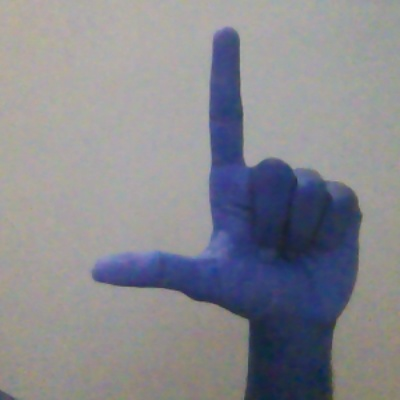


Resultado del Pipeline:
  Letra Predicha: L
  Confianza:      100.00%
  Status:         Éxito


In [21]:
clasificar_imagen("/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/Test/L/3003.jpg")